# Generalized Matrix Factorization (GMF)

.

In [0]:
import matplotlib.pyplot as plt
import argparse
import tensorflow as tf
import sys
import os.path
import tensorflow as tf
import time
import numpy as np
import math
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
import random

# Load Data

In [0]:
df = pd.read_csv('train.csv', sep=',', error_bad_lines=False, encoding="latin-1")

In [47]:
df.head()

,user,event,invited,timestamp,interested,not_interested
0,3044012,1918771225,0,2012-10-02 15:53:05.754000+00:00,0,0
1,3044012,1502284248,0,2012-10-02 15:53:05.754000+00:00,0,0
2,3044012,2529072432,0,2012-10-02 15:53:05.754000+00:00,1,0
3,3044012,3072478280,0,2012-10-02 15:53:05.754000+00:00,0,0
4,3044012,1390707377,0,2012-10-02 15:53:05.754000+00:00,0,0


#Prepare Data

In [48]:
df = df.drop('invited', axis=1).drop('timestamp', axis=1).drop('not_interested', axis=1)
df.shape

(15398, 3)

In [49]:
#index users
users = df.user.unique()
usersdf = pd.DataFrame(users)
usersdf.head()

,0
0,3044012
1,4236494
2,5574997
3,7547671
4,10329108


In [50]:
usersdf['user_id'] = usersdf.index +1
usersdf.columns = ["user","user_id"]
usersdf.head()


,user,user_id
0,3044012,1
1,4236494,2
2,5574997,3
3,7547671,4
4,10329108,5


In [51]:
#index events
events = df.event.unique()
eventsdf = pd.DataFrame(events)
eventsdf['eventid'] = eventsdf.index +1
eventsdf.columns = ["event","eventid"]
eventsdf.head()

,event,eventid
0,1918771225,1
1,1502284248,2
2,2529072432,3
3,3072478280,4
4,1390707377,5


In [52]:
df = pd.merge(df, usersdf, on='user')
df = pd.merge(df, eventsdf, on='event')
df.head()

,user,event,interested,user_id,eventid
0,3044012,1918771225,0,1,1
1,1906220044,1918771225,0,884,1
2,3044012,1502284248,0,1,2
3,1302145719,1502284248,0,633,2
4,3194014105,1502284248,0,1500,2


In [53]:
df = df.drop("user", axis=1).drop("event", axis=1)
df.head()

,interested,user_id,eventid
0,0,1,1
1,0,884,1
2,0,1,2
3,0,633,2
4,0,1500,2


In [54]:
df = df[['user_id', 'eventid', 'interested']]
df.head()

,user_id,eventid,interested
0,1,1,0
1,884,1,0
2,1,2,0
3,633,2,0
4,1500,2,0


In [55]:
df.shape

(15398, 3)

# Model

In [0]:
import math


# efficient version
def precision_recall_ndcg_at_k(k, rankedlist, test_matrix):
    idcg_k = 0
    dcg_k = 0
    n_k = k if len(test_matrix) > k else len(test_matrix)
    for i in range(n_k):
        idcg_k += 1 / math.log(i + 2, 2)

    b1 = rankedlist
    b2 = test_matrix
    s2 = set(b2)
    hits = [(idx, val) for idx, val in enumerate(b1) if val in s2]
    count = len(hits)

    for c in range(count):
        dcg_k += 1 / math.log(hits[c][0] + 2, 2)

    return float(count / k), float(count / len(test_matrix)), float(dcg_k / idcg_k)


def map_mrr_ndcg(rankedlist, test_matrix):
    ap = 0
    map = 0
    dcg = 0
    idcg = 0
    mrr = 0
    for i in range(len(test_matrix)):
        idcg += 1 / math.log(i + 2, 2)

    b1 = rankedlist
    b2 = test_matrix
    s2 = set(b2)
    hits = [(idx, val) for idx, val in enumerate(b1) if val in s2]
    count = len(hits)

    for c in range(count):
        ap += (c + 1) / (hits[c][0] + 1)
        dcg += 1 / math.log(hits[c][0] + 2, 2)

    if count != 0:
        mrr = 1 / (hits[0][0] + 1)

    if count != 0:
        map = ap / count

    return map, mrr, float(dcg / idcg)


def evaluate(self):
    pred_ratings_10 = {}
    pred_ratings_5 = {}
    pred_ratings = {}
    ranked_list = {}
    p_at_5 = []
    p_at_10 = []
    r_at_5 = []
    r_at_10 = []
    map = []
    mrr = []
    ndcg = []
    ndcg_at_5 = []
    ndcg_at_10 = []
    for u in self.test_users:
        user_ids = []
        user_neg_items = self.neg_items[u]
        item_ids = []
        # scores = []
        for j in user_neg_items:
            item_ids.append(j)
            user_ids.append(u)

        scores = self.predict(user_ids, item_ids)
        # print(type(scores))
        # print(scores)
        # print(np.shape(scores))
        # print(ratings)
        neg_item_index = list(zip(item_ids, scores))

        ranked_list[u] = sorted(neg_item_index, key=lambda tup: tup[1], reverse=True)
        pred_ratings[u] = [r[0] for r in ranked_list[u]]
        pred_ratings_5[u] = pred_ratings[u][:5]
        pred_ratings_10[u] = pred_ratings[u][:10]

        p_5, r_5, ndcg_5 = precision_recall_ndcg_at_k(5, pred_ratings_5[u], self.test_data[u])
        p_at_5.append(p_5)
        r_at_5.append(r_5)
        ndcg_at_5.append(ndcg_5)
        p_10, r_10, ndcg_10 = precision_recall_ndcg_at_k(10, pred_ratings_10[u], self.test_data[u])
        p_at_10.append(p_10)
        r_at_10.append(r_10)
        ndcg_at_10.append(ndcg_10)
        map_u, mrr_u, ndcg_u = map_mrr_ndcg(pred_ratings[u], self.test_data[u])
        map.append(map_u)
        mrr.append(mrr_u)
        ndcg.append(ndcg_u)
    print("-----------------------------------------------------")
    print("precision@5: " + str(np.mean(p_at_5)))
    print("recall@5: " + str(np.mean(r_at_5)))
    return np.mean(p_at_5), np.mean(r_at_5)

In [0]:
class GMF():
    def __init__(self, sess, num_user, num_item, learning_rate=0.5, reg_rate=0.01, epoch=25, batch_size=256,
                 verbose=False, T=1, display_step=1):
        self.learning_rate = learning_rate
        self.epochs = epoch
        self.batch_size = batch_size
        self.reg_rate = reg_rate
        self.sess = sess
        self.num_user = num_user
        self.num_item = num_item
        self.verbose = verbose
        self.T = T
        self.display_step = display_step
        print("NeuMF.")

    def build_network(self, num_factor=10, num_neg_sample=20):
        self.num_neg_sample = num_neg_sample
        self.user_id = tf.placeholder(dtype=tf.int32, shape=[None], name='user_id')
        self.item_id = tf.placeholder(dtype=tf.int32, shape=[None], name='item_id')
        self.y = tf.placeholder(dtype=tf.float32, shape=[None], name='y')

        self.P = tf.Variable(tf.random_normal([self.num_user, num_factor]), dtype=tf.float32)
        self.Q = tf.Variable(tf.random_normal([self.num_item, num_factor]), dtype=tf.float32)

        user_latent_factor = tf.nn.embedding_lookup(self.P, self.user_id)
        item_latent_factor = tf.nn.embedding_lookup(self.Q, self.item_id)
        GMF = tf.multiply(user_latent_factor, item_latent_factor)

        self.pred_y = tf.nn.sigmoid(tf.reduce_sum(GMF, axis=1))

        self.loss = - tf.reduce_sum(
            self.y * tf.log(self.pred_y + 1e-10) + (1 - self.y) * tf.log(1 - self.pred_y + 1e-10)) \
                    + self.reg_rate * (tf.nn.l2_loss(self.P) + tf.nn.l2_loss(self.Q))

        self.optimizer = tf.train.AdagradOptimizer(self.learning_rate).minimize(self.loss)

        return self

    def prepare_data(self, train_data, test_data):
        '''
        You must prepare the data before train and test the model
        :param train_data:
        :param test_data:
        :return:
        '''
        t = train_data.tocoo()
        self.user = list(t.row.reshape(-1))
        self.item = list(t.col.reshape(-1))
        self.label = list(t.data)
        self.test_data = test_data

        self.neg_items = self._get_neg_items(train_data.tocsr())
        self.test_users = set([u for u in self.test_data.keys() if len(self.test_data[u]) > 0])

        print("data preparation finished.")
        return self

    def train(self):

        item_temp = self.item[:]
        user_temp = self.user[:]
        labels_temp = self.label[:]

        user_append = []
        item_append = []
        values_append = []
        for u in self.user:
            list_of_random_items = random.sample(self.neg_items[u], self.num_neg_sample)
            user_append += [u] * self.num_neg_sample
            item_append += list_of_random_items
            values_append += [0] * self.num_neg_sample

        item_temp += item_append
        user_temp += user_append
        labels_temp += values_append

        self.num_training = len(item_temp)
        self.total_batch = int(self.num_training / self.batch_size)
        # print(self.total_batch)
        idxs = np.random.permutation(self.num_training)  # shuffled ordering
        user_random = list(np.array(user_temp)[idxs])
        item_random = list(np.array(item_temp)[idxs])
        labels_random = list(np.array(labels_temp)[idxs])

        # train
        for i in range(self.total_batch):
            start_time = time.time()
            batch_user = user_random[i * self.batch_size:(i + 1) * self.batch_size]
            batch_item = item_random[i * self.batch_size:(i + 1) * self.batch_size]
            batch_label = labels_random[i * self.batch_size:(i + 1) * self.batch_size]

            _, loss = self.sess.run((self.optimizer, self.loss),
                                    feed_dict={self.user_id: batch_user, self.item_id: batch_item, self.y: batch_label})

            if i % self.display_step == 0:
                if self.verbose:
                    print("Index: %04d; cost= %.9f" % (i + 1, np.mean(loss)))
                    print("one iteration: %s seconds." % (time.time() - start_time))

    def test(self):
         precision, recall = evaluate(self)
         return precision, recall

    def execute(self, train_data, test_data):

        self.prepare_data(train_data, test_data)

        init = tf.global_variables_initializer()
        self.sess.run(init)
        precision =[]
        recall = []
        for epoch in range(self.epochs):
            self.train()
            if (epoch) % self.T == 0:
                print("Epoch: %04d; " % (epoch), end='')
                prec, rec = self.test()
                precision.append(prec)
                recall.append(rec)
        return precision, recall

    def save(self, path):
        saver = tf.train.Saver()
        saver.save(self.sess, path)

    def predict(self, user_id, item_id):
        return self.sess.run([self.pred_y], feed_dict={self.user_id: user_id, self.item_id: item_id})[0]

    def _get_neg_items(self, data):
        all_items = set(np.arange(self.num_item))
        neg_items = {}
        for u in range(self.num_user):
            neg_items[u] = list(all_items - set(data.getrow(u).nonzero()[1]))

        return neg_items

In [0]:
def load_data_neg(test_size=0.2, sep="\t"):
   
    n_users = df.user_id.unique().shape[0]
    n_items = df.eventid.unique().shape[0]

    train_data, test_data = train_test_split(df, test_size=test_size)
    train_data = pd.DataFrame(train_data)
    test_data = pd.DataFrame(test_data)

    train_row = []
    train_col = []
    train_rating = []

    for line in train_data.itertuples():
        u = line[1] - 1
        i = line[2] - 1
        train_row.append(u)
        train_col.append(i)
        train_rating.append(line[3])
    train_matrix = csr_matrix((train_rating, (train_row, train_col)), shape=(n_users, n_items))

    # all_items = set(np.arange(n_items))
    # neg_items = {}
    # for u in range(n_users):
    #     neg_items[u] = list(all_items - set(train_matrix.getrow(u).nonzero()[1]))

    test_row = []
    test_col = []
    test_rating = []
    for line in test_data.itertuples():
        test_row.append(line[1] - 1)
        test_col.append(line[2] - 1)
        test_rating.append(line[3])
    test_matrix = csr_matrix((test_rating, (test_row, test_col)), shape=(n_users, n_items))

    test_dict = {}
    for u in range(n_users):
        test_dict[u] = test_matrix.getrow(u).nonzero()[1]

    print("Load data finished. Number of users:", n_users, "Number of items:", n_items)
    return train_matrix.todok(), test_dict, n_users, n_items





#Evaluate

In [68]:
import matplotlib.pyplot as plt

model ='GMF'
epochs = 25
num_factors = 10
display_step = 10
batch_size = 100  # 128 for unlimpair
learning_rate = 1e-3  # 1e-4 for unlimpair
reg_rate = 0.1  # 0.01 for unlimpair
train_data, test_data, n_user, n_item = load_data_neg(test_size=0.2, sep="\t")

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.Session(config=config) as sess:
    model = GMF(sess, n_user, n_item)
    model.build_network()
    precision, recall=model.execute(train_data, test_data)
    
print('Done!!')
    
    


Load data finished. Number of users: 2034 Number of items: 8846
NeuMF.
data preparation finished.
Epoch: 0000; -----------------------------------------------------
precision@5: 0.007598784194528876
recall@5: 0.03242147922998987
Epoch: 0001; -----------------------------------------------------
precision@5: 0.007598784194528876
recall@5: 0.034954407294832825
Epoch: 0002; -----------------------------------------------------
precision@5: 0.016717325227963525
recall@5: 0.0707193515704154
Epoch: 0003; -----------------------------------------------------
precision@5: 0.01762917933130699
recall@5: 0.0733789260385005
Epoch: 0004; -----------------------------------------------------
precision@5: 0.013677811550151978
recall@5: 0.05965045592705167
Epoch: 0005; -----------------------------------------------------
precision@5: 0.015197568389057751
recall@5: 0.06426038500506585
Epoch: 0006; -----------------------------------------------------
precision@5: 0.02218844984802432
recall@5: 0.090400

**Precision**

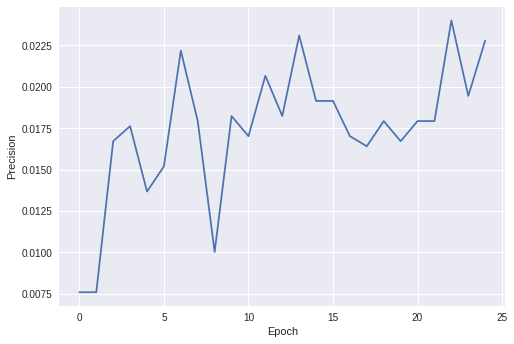

In [69]:
plt.plot(precision)
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.show()

**Recall**

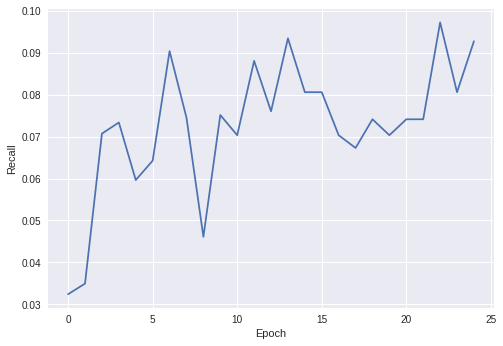

In [70]:
plt.plot(recall)
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.show()

# References

https://www.comp.nus.edu.sg/~xiangnan/papers/ncf.pdf